In [1]:
 # Import necessary libraries
import torch
from torch import nn #torch building blocks for neural networks (graphs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Setup device-agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [3]:
#binary classification: yes/no, true/false, ect (one thing or another)

#multiclass classification: a/b/c? (more than one thing or another)->one label to each sample

#multilabel classification: each sample can have several labels

In [4]:
#nn.Linear()<- a layer!
#hidden layer: more layers<- number of neurons hidden shown in in_features
#hidden layer activation: nn.ReLU()<-rectified linear unit

In [5]:
from sklearn.datasets import make_circles

#make 1000 samples
n_samples=1000
#creating circles
x,y=make_circles(n_samples,noise=0.03,random_state=42)

In [6]:
len(x),len(y)

(1000, 1000)

In [7]:
print(x[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [8]:
circles=pd.DataFrame({"X1":x[:,0],
                     "X2":x[:,1],
                     "label":y})

In [9]:
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


1


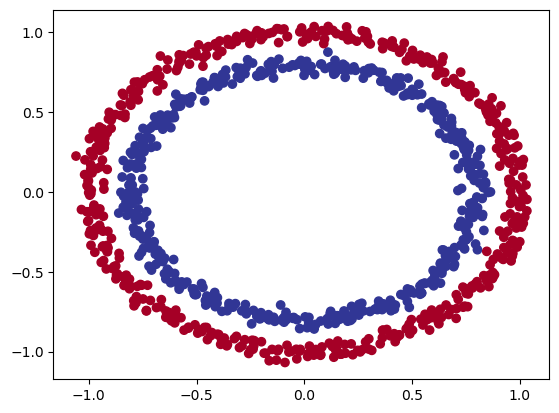

In [10]:
plt.scatter(circles['X1'],circles['X2'],c=circles['label'],cmap=plt.cm.RdYlBu)
print(circles['label'][0])

In [11]:
#we're working with a 'toy' dataset
#small enough to fuck around, big enough to find out

In [12]:
x.shape,y.shape

((1000, 2), (1000,))

In [13]:
X=torch.from_numpy(x).type(torch.float)
Y=torch.from_numpy(y).type(torch.float)
X=X.to(device)
Y=Y.to(device)
X[:5],Y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
X.dtype,Y.dtype

(torch.float32, torch.float32)

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
len(X_train),len(X_test),len(Y_train),len(Y_test)

(800, 200, 800, 200)

In [16]:
Y_train.shape

torch.Size([800])

In [17]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=8)#out feat is hidden layer
    self.layer_2=nn.Linear(in_features=8,out_features=1)#prev out==current in

  def forward(self,x):
    return self.layer_2(self.layer_1(x))#x->layer 1-> layer 2->output

model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cpu')

In [19]:
#we can do it with nn.Sequential

#model_0=nn.Sequential(nn.Linear(in_features=2,out_features=8),nn.Linear(in_features=8,out_features=1)).to(device)

In [20]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.1854,  0.0607],
                      [-0.2693,  0.2107],
                      [-0.6181, -0.6554],
                      [-0.3853, -0.3852],
                      [ 0.3999, -0.2389],
                      [-0.6941,  0.6923],
                      [ 0.2648, -0.0452],
                      [ 0.6923, -0.5072]])),
             ('layer_1.bias',
              tensor([ 0.2988,  0.3827, -0.4929, -0.6971,  0.5326,  0.1019, -0.6939, -0.4342])),
             ('layer_2.weight',
              tensor([[-0.2214,  0.1276, -0.0378, -0.0307,  0.0991, -0.2889, -0.2222,  0.1760]])),
             ('layer_2.bias', tensor([0.2451]))])

In [21]:
untrained_preds=model_0(X_test)
#untrained_preds

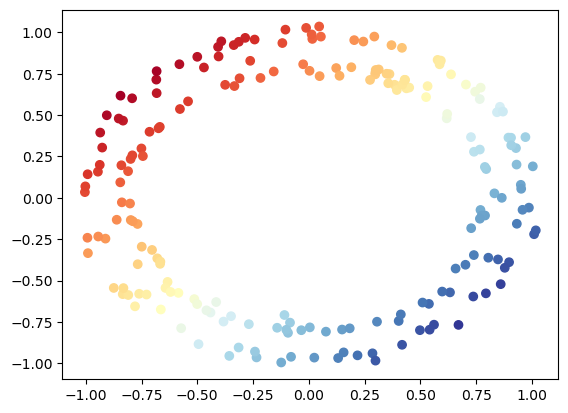

In [22]:
#plt.scatter(X_test[:,0].to("cpu"),X_test[:,1].to("cpu"),c=Y_test.to("cpu"),cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:,0].to("cpu"),X_test[:,1].to("cpu"),c=untrained_preds.to("cpu").detach().numpy(),cmap=plt.cm.RdYlBu)

In [23]:
#which loss function should we use?

#regression->MAE/MSE (L1/L2)

#binary class->binary cross entropy (basically a function of probability logs added
#                                     for true and false classes)
#                                     version w logits and without


#uuuh a logit is a layer that feeds into aaa idk but better use it
#it's basically implementing a sigmoid ig (curvy step function)
#y=(1-exp(-x))^-1



#multiclassing->cross entropy loss

In [24]:
loss_fn=nn.BCEWithLogitsLoss()#sigmoid activation function built in!

#WithLogitsLoss==nn.Sequential(nn.Sigmoid,nn.BCELoss())
#but it's better to do both together

optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [25]:
#calculate accuracy

#out of 100, how many did we get right?

def accuracy(y_true,y_pred):
  if len(y_true)!=len(y_pred):
    raise Exception("Lengths do not match")
  else:
    correct=(y_true==y_pred).sum().item()
    acc=correct/len(y_pred)
    return acc

In [26]:
(Y_train==Y_train).sum().item()/len(Y_train)

1.0

In [27]:
torch.cuda.manual_seed(42)
epochs=int(1E3)

# Send data to target device


for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_0.train()

  # 1. Forward pass
  Y_pred_new = model_0(X_train).squeeze()

  # 2. Calculate loss
  loss = loss_fn(Y_pred_new,Y_train)
  Y_pred_probs=torch.sigmoid(Y_pred_new).round()
  acc=accuracy(Y_pred_probs,Y_train)*100

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  model_0.eval()

  ### Perform testing every 20 epochs
  sep=100
  if epoch % sep == 0:
    if epoch==0:
      spaces=" "*int(np.log10(epochs/sep))
    else:
      spaces=""
    # Put model in evaluation mode and setup inference context
    with torch.inference_mode():
      # 1. Forward pass a logit
      y_logits = model_0(X_test).squeeze()
      # 2. Turn into prediction probs
      y_pred_probs=torch.sigmoid(y_logits)
      # 3. Find predicted labels
      y_pred_probs=torch.round(y_pred_probs) #p>=0.5->TRUE p<0.5->FALSE
      # 2. Calculate test loss
      test_loss = loss_fn(y_logits,Y_test)
      t_acc=accuracy(Y_test,y_pred_probs)*100
      # Print out what's happening
      print(f"Epoch: {epoch}{spaces} | Train loss: {loss:.4f} | Test loss: {test_loss:.4f} | Train Accuracy: {acc:.2f} |Test accuracy: {t_acc:.2f}%")

Epoch: 0  | Train loss: 0.7179 | Test loss: 0.7119 | Train Accuracy: 51.38 |Test accuracy: 51.00%
Epoch: 100 | Train loss: 0.7037 | Test loss: 0.6982 | Train Accuracy: 52.50 |Test accuracy: 57.50%
Epoch: 200 | Train loss: 0.6992 | Test loss: 0.6943 | Train Accuracy: 51.62 |Test accuracy: 53.00%
Epoch: 300 | Train loss: 0.6971 | Test loss: 0.6928 | Train Accuracy: 51.25 |Test accuracy: 49.00%
Epoch: 400 | Train loss: 0.6959 | Test loss: 0.6922 | Train Accuracy: 51.12 |Test accuracy: 50.00%
Epoch: 500 | Train loss: 0.6952 | Test loss: 0.6920 | Train Accuracy: 50.38 |Test accuracy: 50.00%
Epoch: 600 | Train loss: 0.6946 | Test loss: 0.6919 | Train Accuracy: 50.12 |Test accuracy: 51.00%
Epoch: 700 | Train loss: 0.6942 | Test loss: 0.6920 | Train Accuracy: 50.38 |Test accuracy: 52.00%
Epoch: 800 | Train loss: 0.6939 | Test loss: 0.6921 | Train Accuracy: 50.38 |Test accuracy: 52.50%
Epoch: 900 | Train loss: 0.6937 | Test loss: 0.6922 | Train Accuracy: 50.50 |Test accuracy: 53.00%


In [28]:
#our model ain't learing a thing!!

#visualization

#we want to import a thingy from Goku
import requests
from pathlib import Path
import os

#download from learn pytorch repo if not downloaded

if Path("helper_functions.py").is_file():
  print(f"helper_functions.py already exists\n")
  #print("Deleting previous instance")
  #os.remove("helper_functions.py")
else:
  print("Downloading file...")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

helper_functions.py already exists



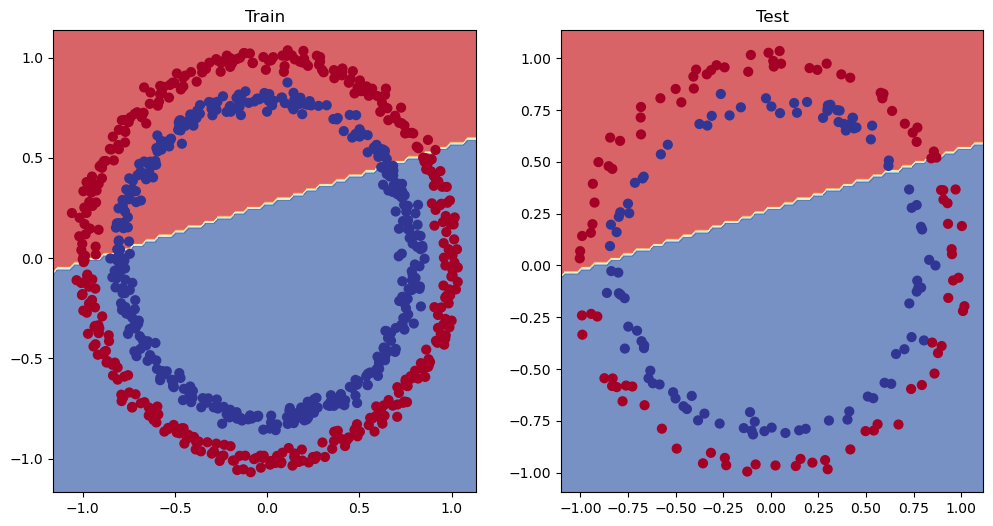

In [29]:
import helper_functions as hf
import importlib
importlib.reload(hf)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plt.title("Train")

hf.plot_decision_boundary(model_0,X_train,Y_train)
plt.subplot(1,2,2)

plt.subplot(1,2,2)

plt.title("Test")

hf.plot_decision_boundary(model_0,X_test,Y_test)

In [30]:
#What can we change (hyperparameters)

#-Add more layers
#-Add more hidden units
#-Fit for longer (more epochs)
#-Change activation functions (nn.ReLU, or nonlinear)<-imp here
#-Change learing rate in optimizer
#-Change loss function
#-Transfer learining<-use pretrained model to test our data

In [31]:
#can our model fit a straight line?
weights=0.7
bias=0.3

start=0
end=1
step=0.01
X_line=torch.arange(start,end,step).unsqueeze(dim=1)
X_line=X_line.to(device)
Y_line=weights*X_line+bias

split=int(0.8*len(X_line))
X_train_line,Y_train_line=X_line[:split],Y_line[:split]
X_test_line,Y_test_line=X_line[split:],Y_line[split:]

In [32]:
model_linreg=nn.Sequential(nn.Linear(in_features=1,out_features=8),
                           nn.Linear(in_features=8,out_features=1)).to(device)
model_linreg

Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [33]:
loss_fn=nn.L1Loss()#sigmoid activation function built in!

#WithLogitsLoss==nn.Sequential(nn.Sigmoid,nn.BCELoss())
#but it's better to do both together

optimizer=torch.optim.SGD(params=model_linreg.parameters(),lr=0.01)

In [34]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs=int(1E3)

# Send data to target device


for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_linreg.train()

  # 1. Forward pass
  Y_pred_line = model_linreg(X_train_line)

  # 2. Calculate loss
  loss = loss_fn(Y_pred_line,Y_train_line)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  model_linreg.eval()

  ### Perform testing every 20 epochs
  sep=100
  if epoch % sep == 0:
    if epoch==0:
      spaces=" "*int(np.log10(sep))
    else:
      spaces=""
    # Put model in evaluation mode and setup inference context
    with torch.inference_mode():
      # 1. Forward pass
      y_logits = model_linreg(X_test_line)
      # 2. Calculate test loss
      test_loss = loss_fn(y_logits,Y_test_line)
      # Print out what's happening
      print(f"Epoch: {epoch}{spaces} | Train loss: {loss:.4f} | Test loss: {test_loss:.4f} |")

Epoch: 0   | Train loss: 0.4425 | Test loss: 0.9715 |
Epoch: 100 | Train loss: 0.1145 | Test loss: 0.2632 |
Epoch: 200 | Train loss: 0.0260 | Test loss: 0.0580 |
Epoch: 300 | Train loss: 0.0268 | Test loss: 0.0153 |
Epoch: 400 | Train loss: 0.0313 | Test loss: 0.0079 |
Epoch: 500 | Train loss: 0.0358 | Test loss: 0.0016 |
Epoch: 600 | Train loss: 0.0372 | Test loss: 0.0029 |
Epoch: 700 | Train loss: 0.0357 | Test loss: 0.0026 |
Epoch: 800 | Train loss: 0.0358 | Test loss: 0.0040 |
Epoch: 900 | Train loss: 0.0344 | Test loss: 0.0037 |


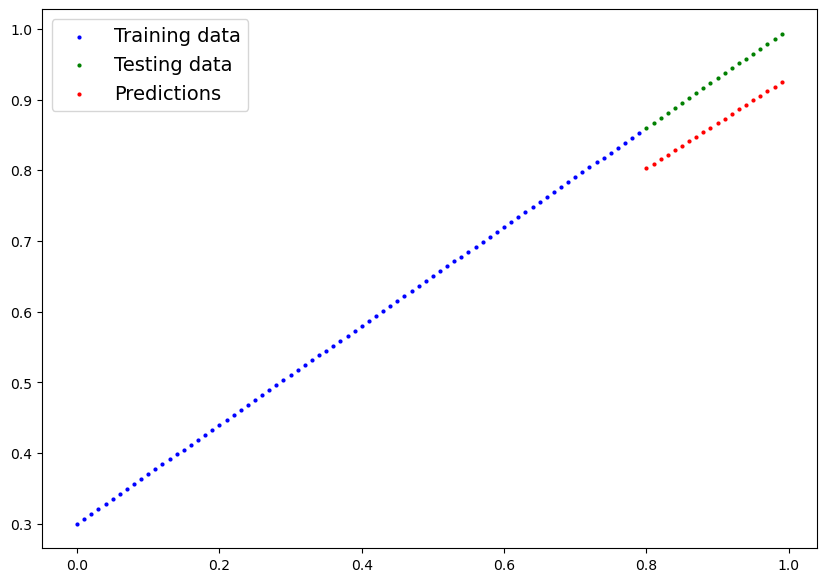

In [35]:
model_linreg.eval()

with torch.inference_mode():
  y_preds_line=model_linreg(X_test_line)

hf.plot_predictions(X_train_line.cpu(),Y_train_line.cpu(),X_test_line.cpu(),Y_test_line.cpu(),y_preds_line.cpu())

In [36]:
##works with linear... not with non-linear -> maybe we need non linear functions

In [37]:
#let's goo with the nonlinearity!!!!!!

In [38]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=16)
    self.layer_2=nn.Linear(in_features=16,out_features=16)
    self.layer_3=nn.Linear(in_features=16,out_features=1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [39]:
from sklearn.model_selection import train_test_split
X=X.to(device)
Y=Y.to(device)

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [40]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
model_2=CircleModelV2().to(device)

loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.02)

In [41]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs=int(1E4)

# Send data to target device


for epoch in range(epochs):
  ### Training

  # Put model in train mode
  model_2.train()

  # 1. Forward pass
  Y_logits= model_2(X_train).squeeze()
  #turn into pred probs
  Y_pred=torch.sigmoid(Y_logits).round()

  # 2. Calculate loss
  loss = loss_fn(Y_logits,Y_train)
  acc=accuracy(Y_pred,Y_train)*100

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  model_2.eval()

  ### Perform testing every 20 epochs
  sep=int(epochs/10)
  if epoch % sep == 0:
    if epoch==0:
      spaces=" "*int(np.log10(sep))
    else:
      spaces=""
    # Put model in evaluation mode and setup inference context
    with torch.inference_mode():
      # 1. Forward pass
      y_logits = model_2(X_test).squeeze()
      # 2. Calculate test loss
      test_loss = loss_fn(y_logits,Y_test)
      # 3. Accuracy
      y_pred=torch.sigmoid(y_logits).round()
      t_acc=accuracy(y_pred,Y_test)*100
      # Print out what's happening
      print(f"Epoch: {epoch}{spaces} | Train loss: {loss:.4f} | Test loss: {test_loss:.4f} | Accuracy: {acc:.2f}| Test Accuracy: {t_acc:.2f}")

Epoch: 0    | Train loss: 0.6975 | Test loss: 0.6982 | Accuracy: 50.00| Test Accuracy: 50.00
Epoch: 1000 | Train loss: 0.6866 | Test loss: 0.6888 | Accuracy: 52.88| Test Accuracy: 52.00
Epoch: 2000 | Train loss: 0.6773 | Test loss: 0.6819 | Accuracy: 54.00| Test Accuracy: 53.50
Epoch: 3000 | Train loss: 0.6593 | Test loss: 0.6678 | Accuracy: 62.62| Test Accuracy: 58.00
Epoch: 4000 | Train loss: 0.6125 | Test loss: 0.6289 | Accuracy: 87.38| Test Accuracy: 85.00
Epoch: 5000 | Train loss: 0.4810 | Test loss: 0.5166 | Accuracy: 99.25| Test Accuracy: 97.00
Epoch: 6000 | Train loss: 0.2354 | Test loss: 0.2856 | Accuracy: 100.00| Test Accuracy: 99.50
Epoch: 7000 | Train loss: 0.0931 | Test loss: 0.1336 | Accuracy: 100.00| Test Accuracy: 100.00
Epoch: 8000 | Train loss: 0.0463 | Test loss: 0.0766 | Accuracy: 100.00| Test Accuracy: 100.00
Epoch: 9000 | Train loss: 0.0287 | Test loss: 0.0537 | Accuracy: 100.00| Test Accuracy: 100.00


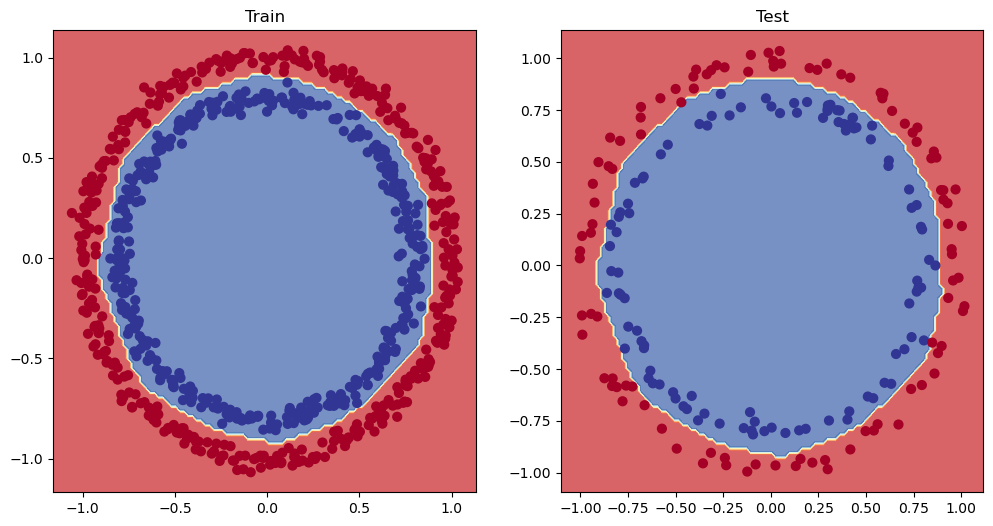

In [42]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plt.title("Train")

hf.plot_decision_boundary(model_2,X_train,Y_train)
plt.subplot(1,2,2)

plt.subplot(1,2,2)

plt.title("Test")

hf.plot_decision_boundary(model_2,X_test,Y_test)

In [43]:
##Replicating a Non-Linear Funtion

In [44]:
A=torch.arange(-10,10,dtype=torch.float32)

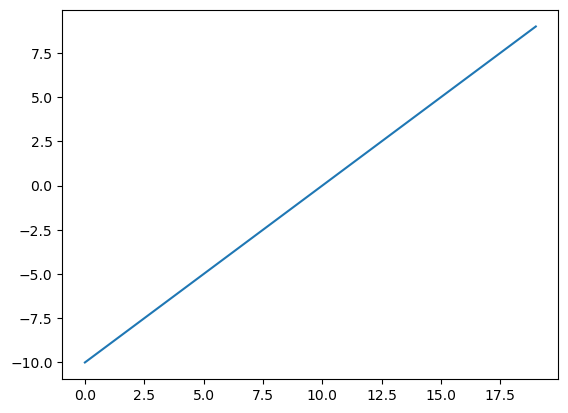

In [45]:
plt.plot(A)

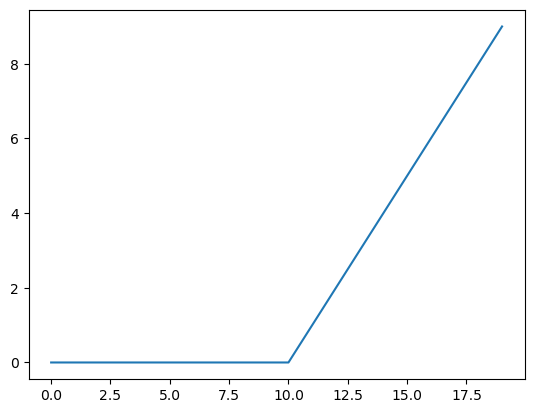

In [46]:
plt.plot(torch.relu(A))

In [47]:
def RELU(x):
  return torch.max(torch.tensor(0),x)

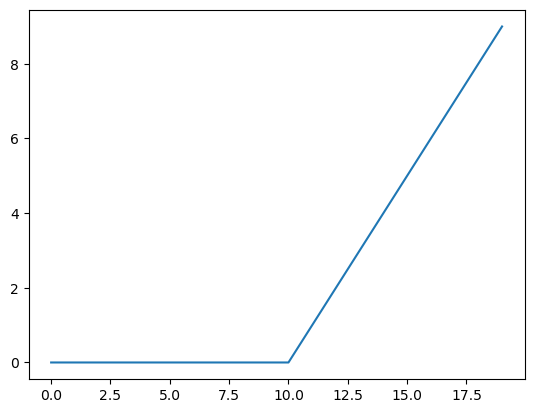

In [48]:
plt.plot(RELU(A))

In [49]:
def sigma(x):
  return 1/(1+torch.exp(-x))

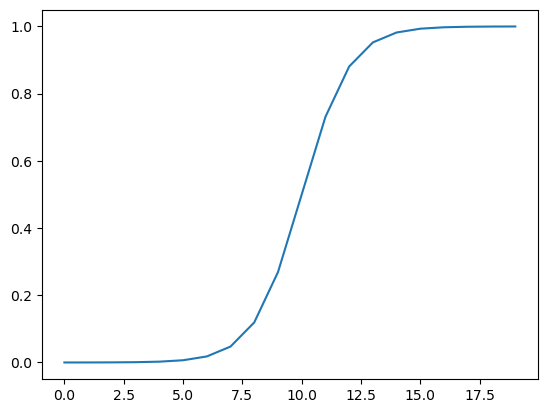

In [50]:
plt.plot(sigma(A))

In [51]:
#toy multiclass dataset

from sklearn.datasets import make_blobs

X_blob,Y_blob=make_blobs(n_samples=1000,n_features=2,centers=4,random_state=42,cluster_std=1.5)
X_blob=torch.from_numpy(X_blob).type(torch.float).to(device)
Y_blob=torch.from_numpy(Y_blob).type(torch.long).to(device)#must be int!!!
X_blob.shape,Y_blob.shape,torch.unique(Y_blob)

(torch.Size([1000, 2]), torch.Size([1000]), tensor([0, 1, 2, 3]))

In [52]:
X_blob_train,X_blob_test,Y_blob_train,Y_blob_test=train_test_split(X_blob,Y_blob,test_size=0.2,random_state=42)
#X_blob_train,X_blob_test,Y_blob_train,Y_blob_test=X_blob_train.type(torch.long),X_blob_test.type(torch.long),Y_blob_train.type(torch.long),Y_blob_test.type(torch.long)

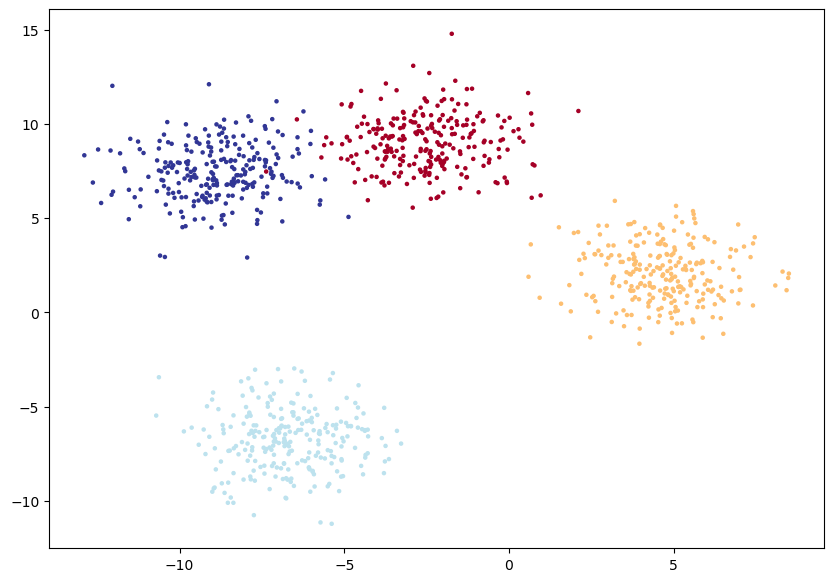

In [53]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0].cpu(),X_blob[:,1].cpu(),c=Y_blob.cpu(),cmap=plt.cm.RdYlBu,s=5)

In [54]:
#build multiclass (4 class) model

class TheBlob(nn.Module):
  def __init__(self,input,output,hidden):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(nn.Linear(in_features=input,out_features=hidden),
                                          nn.ReLU(),
                                          nn.Linear(in_features=hidden,out_features=hidden),
                                          nn.ReLU(),
                                          nn.Linear(in_features=hidden,out_features=output))
  def forward(self,x):
    return self.linear_layer_stack(x)

model_blob=TheBlob(input=2,output=4,hidden=8).to(device)
model_blob

TheBlob(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [55]:
#uuuh create loss and optimizer

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_blob.parameters(),lr=1)

model_blob(X_blob_train)

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        ...,
        [-0.2564, -1.2652, -1.0365, -0.3130],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.0502, -0.8423, -0.4798, -0.0988]], grad_fn=<AddmmBackward0>)

In [56]:
model_blob=TheBlob(input=2,output=4,hidden=8).to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_blob.parameters(),lr=0.01)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=int(1E3)

#X_blob_train,X_blob_test,Y_blob_train,Y_blob_test=X_blob_train.type(torch.long),X_blob_test.type(torch.long),Y_blob_train.type(torch.long),Y_blob_test.type(torch.long)

for epoch in range(epochs):
  model_blob.train()

  y_logits=model_blob(X_blob_train)
  #y_logits2,trash=torch.max(y_logits,dim=1)

  #turn our classes into prediction probs
  y_pred_prob=torch.softmax(y_logits,dim=1)#SOFTMAX FOR MULTICLASS!!!

  y_pred=y_pred_prob.argmax(dim=1)#which one is the right label (0-3)?
  loss=loss_fn(y_logits,Y_blob_train)
  acc=accuracy(y_pred,Y_blob_train)*100

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_blob.eval()

  if epoch % (epochs/10)==0:
    if epoch==0:
      spaces=" "*int(np.log10(epochs/10))
    else:
      spaces=""

    with torch.inference_mode():
      y_logits_t=model_blob(X_blob_test).squeeze()

      y_pred_prob_t=torch.softmax(y_logits_t,dim=1)
      y_pred_t=y_pred_prob_t.argmax(dim=1)

      loss_t=loss_fn(y_logits_t,Y_blob_test)
      acc_t=accuracy(y_pred_t,Y_blob_test)*100
    print(f"Epoch: {epoch}{spaces} | Train loss: {loss:.4f} | Test loss: {loss_t:.4f} | Accuracy: {acc:.2f} | Test accuracy: {acc_t:.2f}")

Epoch: 0   | Train loss: 1.3748 | Test loss: 1.3357 | Accuracy: 49.38 | Test accuracy: 51.00
Epoch: 100 | Train loss: 0.6664 | Test loss: 0.5818 | Accuracy: 72.62 | Test accuracy: 79.00
Epoch: 200 | Train loss: 0.5020 | Test loss: 0.4265 | Accuracy: 73.12 | Test accuracy: 79.00
Epoch: 300 | Train loss: 0.4094 | Test loss: 0.3438 | Accuracy: 80.75 | Test accuracy: 83.50
Epoch: 400 | Train loss: 0.3382 | Test loss: 0.2833 | Accuracy: 87.50 | Test accuracy: 90.00
Epoch: 500 | Train loss: 0.2569 | Test loss: 0.2152 | Accuracy: 95.25 | Test accuracy: 97.00
Epoch: 600 | Train loss: 0.1550 | Test loss: 0.1303 | Accuracy: 98.38 | Test accuracy: 99.00
Epoch: 700 | Train loss: 0.0932 | Test loss: 0.0778 | Accuracy: 98.88 | Test accuracy: 99.00
Epoch: 800 | Train loss: 0.0669 | Test loss: 0.0551 | Accuracy: 98.88 | Test accuracy: 99.00
Epoch: 900 | Train loss: 0.0543 | Test loss: 0.0444 | Accuracy: 98.88 | Test accuracy: 99.00


In [57]:
x,y=torch.max(torch.rand(10,4),dim=1)
x

tensor([0.9593, 0.7936, 0.9408, 0.8694, 0.8854, 0.8317, 0.3588, 0.9516, 0.8860,
        0.9040])

In [58]:
model_blob.eval()

with torch.inference_mode():
  y_logits=model_blob(X_blob_test)
  y_pred_prob=torch.softmax(y_logits,dim=1)
  y_pred=y_pred_prob.argmax(dim=1)

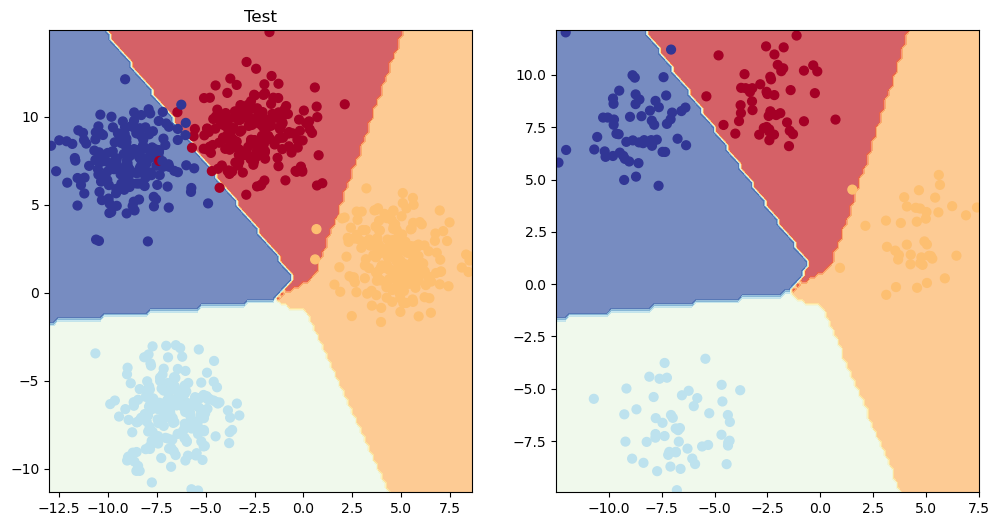

In [59]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plt.title("Train")

hf.plot_decision_boundary(model_blob,X_blob_train,Y_blob_train)

plt.title("Test")

plt.subplot(1,2,2)

hf.plot_decision_boundary(model_blob,X_blob_test,Y_blob_test)

In [60]:
#hey, data is linearly separable!!

In [61]:
#ok
import torchmetrics

In [62]:
acc_metric=torchmetrics.Accuracy(task="multiclass",num_classes=4).to(device)

acc_metric.update(y_pred,Y_blob_test)

acc=acc_metric.compute()

print(f"Accuracy: {acc}")

Accuracy: 0.9900000095367432


In [65]:
%reset -f